In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# Load Data
tickers = ['ETH-USD']

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = web.DataReader(tickers, 'yahoo', start, end)

In [3]:
# Prepare Data (Scaling)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) # Only closing price

prediction_days = 60  # Number of days you want to look into the past.

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):  # Create training sets.
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
# Build the Model
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1))) # Can change the number of units to increase or decrease training.
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True)) # Can change the number of units to increase or decrease training.
model.add(Dropout(0.2))
model.add(LSTM(units = 50)) # Can change the number of units to increase or decrease training.
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next closing value.

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size = 64) # Can tweak batch_size (number of samples looked at one time) or epochs.

Epoch 1/50
25/25 [==============================] - 4s 44ms/step - loss: 0.0274
Epoch 2/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0033
Epoch 3/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0025
Epoch 4/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0023
Epoch 5/50
25/25 [==============================] - 1s 40ms/step - loss: 0.0020
Epoch 6/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0017
Epoch 7/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0020
Epoch 8/50
25/25 [==============================] - 1s 40ms/step - loss: 0.0021
Epoch 9/50
25/25 [==============================] - 1s 40ms/step - loss: 0.0018
Epoch 10/50
25/25 [==============================] - 1s 42ms/step - loss: 0.0016
Epoch 11/50
25/25 [==============================] - 1s 40ms/step - loss: 0.0016
Epoch 12/50
25/25 [==============================] - 1s 41ms/step - loss: 0.0021
Epoch 13/50
25/25 [==================

In [5]:
'''Testing Model's Accuracy on Existing Data'''

# Load Test Data
test_start = dt.datetime(2020,1,1)  # Gather data not available to the model
test_end = dt.datetime.now()

test_data = web.DataReader(tickers, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [6]:
# Make Predictions on Test Data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x- prediction_days:x,  0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

<function matplotlib.pyplot.show(close=None, block=None)>

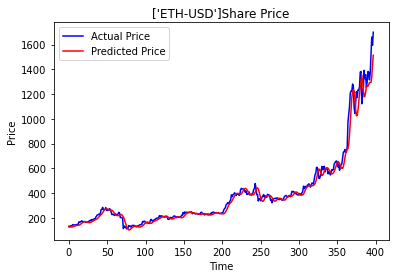

In [7]:
# Plot Test Predictions
plt.plot(actual_prices, color = 'blue', label = "Actual Price")
plt.plot(predicted_prices, color = 'red', label = "Predicted Price")
plt.title(str(tickers) + "Share Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show

In [11]:
# Predicting Next Day's Price

real_data = [model_inputs[len(model_inputs) + 1  - prediction_days: len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print("Prediction:", prediction)

Prediction: [[1577.2026]]
